In [2]:
import pandas as pd
from apriori import Apriori, TransactionEncoder
import statistics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
original_store_data = pd.read_csv("../Dataset/SampleSuperstore.csv")

In [3]:
print(original_store_data.shape)
original_store_data.head()

(9994, 13)


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [4]:
print(original_store_data['Ship Mode'].unique())
print(original_store_data['Segment'].unique())
print(original_store_data['Country'].unique())
print(original_store_data['Category'].unique())
print(original_store_data['Sub-Category'].unique())

['Second Class' 'Standard Class' 'First Class' 'Same Day']
['Consumer' 'Corporate' 'Home Office']
['United States']
['Furniture' 'Office Supplies' 'Technology']
['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [5]:
algorithm = Apriori()
try:
    algorithm.valid_input_check(store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class


#### Changing to a suitable dataframe

In [6]:
store_data = original_store_data[['Postal Code', 'Sub-Category', 'Quantity']]
store_data = store_data.groupby(['Postal Code', 'Sub-Category']).sum()
# Convert quantities to 0/1
store_data['Quantity'] =  (store_data['Quantity']>0).astype(int)
# pivot table and convert it to sparse data
pivoted_store_data = store_data.pivot_table(index='Postal Code', columns='Sub-Category', values='Quantity', fill_value=0)
sparse_store_data = pivoted_store_data.astype(pd.SparseDtype(int, fill_value=0))

In [7]:
print(sparse_store_data.shape)
sparse_store_data.head()

(631, 17)


Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Postal Code,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1


In [8]:
try:
    algorithm.valid_input_check(sparse_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

## Apriori Algorithm and extract frequent items as features 

In [9]:
# check for the mean occurence for each combination 
item_count = algorithm.apriori(df=sparse_store_data, use_colnames=True, verbose=1, count=True, min_support=0.001)

Processing 17 combinations | Sampling itemset size 176531


In [10]:
print(f"Total number of combinations of all itemsets: {len(item_count)}")
average_occurence = round(sum(item_count['count'])/len(item_count), 2)
median_occurence = statistics.median(item_count['count'])
percentile_99 = np.percentile(item_count['count'], 99)
print(f"Average Occurence of each combination: {average_occurence}")
print(f"Median Occurence of each combination: {median_occurence}")
print(f"99 Percentile Occurence of each combination: {percentile_99}")

Total number of combinations of all itemsets: 131071
Average Occurence of each combination: 26.62
Median Occurence of each combination: 23.0
99 Percentile Occurence of each combination: 74.0


In [11]:
item_count.head()

,count,itemsets
0,292.0,(Accessories)
1,223.0,(Appliances)
2,296.0,(Art)
3,402.0,(Binders)
4,138.0,(Bookcases)


In [12]:
new_col = item_count[item_count['count']>=74]['itemsets']

In [13]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

100%|██████████| 1327/1327 [11:39<00:00,  1.90it/s]


In [14]:
original_store_data

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Second Class,Consumer,United States,Miami,Florida,33180,South,Furniture,Furnishings,25.2480,3,0.20,4.1028
9990,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Furniture,Furnishings,91.9600,2,0.00,15.6332
9991,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Technology,Phones,258.5760,2,0.20,19.3932
9992,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.6000,4,0.00,13.3200


In [15]:
# Adding Label to the new table with frequent items as features
final_df = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df = final_df.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df.rename(columns={"Segment": "Label"}, inplace=True)

In [16]:
# Label Transform the Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Label'] = le.fit_transform(final_df['Label'])

In [17]:
# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df.shape)
final_df.head()

(631, 1329)


,Postal Code,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),...,"(Chairs, Paper, Binders, Tables, Furnishings, Storage, Phones)","(Accessories, Phones, Paper, Appliances, Binders, Art, Furnishings, Chairs)","(Accessories, Paper, Appliances, Binders, Art, Furnishings, Storage, Chairs)","(Accessories, Phones, Paper, Appliances, Binders, Art, Storage, Chairs)","(Accessories, Paper, Appliances, Binders, Art, Furnishings, Storage, Phones)","(Accessories, Phones, Paper, Appliances, Binders, Furnishings, Storage, Chairs)","(Accessories, Phones, Paper, Binders, Art, Furnishings, Storage, Chairs)","(Accessories, Paper, Binders, Art, Tables, Furnishings, Storage, Phones)","(Phones, Paper, Appliances, Binders, Art, Furnishings, Storage, Chairs)",Label
0,1040,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1453,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1752,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1810,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1841,0,1,1,1,0,1,0,1,1,...,1,0,0,0,0,0,0,0,1,2


### Data Preprocessing for Clustering Items

In [18]:
new_df = pd.DataFrame(index=sparse_store_data.columns)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for item in sparse_store_data.columns:
        if item not in itemset:
            new_df.at[item, itemset] = 0


100%|██████████| 1327/1327 [00:00<00:00, 4663.37it/s]


In [19]:
final_df2 = new_df.merge(original_store_data[['Sub-Category', 'Category']], how='left', on='Sub-Category').set_index('Sub-Category').drop_duplicates(keep='first')
final_df2.rename(columns={"Category": "Label"}, inplace=True)

le = LabelEncoder()
final_df2['Label'] = le.fit_transform(final_df2['Label'])

In [20]:
# final_df2.to_csv("../Result/SuperStoreFrequentFeatures2.csv")
print(final_df2.shape)
final_df2.head()

(17, 1328)


,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),(Labels),...,"(Chairs, Paper, Binders, Tables, Furnishings, Storage, Phones)","(Accessories, Phones, Paper, Appliances, Binders, Art, Furnishings, Chairs)","(Accessories, Paper, Appliances, Binders, Art, Furnishings, Storage, Chairs)","(Accessories, Phones, Paper, Appliances, Binders, Art, Storage, Chairs)","(Accessories, Paper, Appliances, Binders, Art, Furnishings, Storage, Phones)","(Accessories, Phones, Paper, Appliances, Binders, Furnishings, Storage, Chairs)","(Accessories, Phones, Paper, Binders, Art, Furnishings, Storage, Chairs)","(Accessories, Paper, Binders, Art, Tables, Furnishings, Storage, Phones)","(Phones, Paper, Appliances, Binders, Art, Furnishings, Storage, Chairs)",Label
Sub-Category,,,,,,,,,,,,,,,,,,,,,
Accessories,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,0,2
Appliances,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,0,0,1,1
Art,0,0,1,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,1
Binders,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Bookcases,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering Different Users (based on postal code)

### K Means Clustering (K=7)

In [55]:
print("Number of unique labels: ", len(final_df['Label'].unique()))

Number of unique labels:  7


In [56]:
from sklearn.cluster import KMeans

X = final_df.iloc[:, 1:-1]
kmeans = KMeans(n_clusters=len(final_df['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [57]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")


Silhouette Score: 0.5023896219832708
Calinski Harabasz Score: 225.87844445535706
Davies Bouldin Score: 1.8426762494371418
Adjusted Rand Index: -0.03764385435604647


#### t-SNE

In [58]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

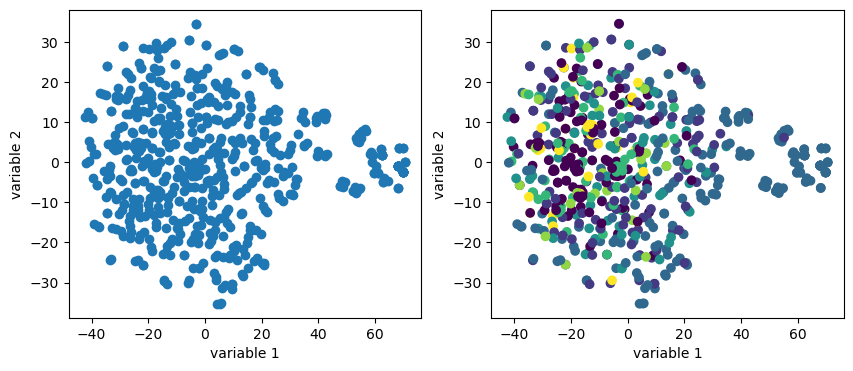

In [59]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [60]:
kmeans = KMeans(n_clusters=len(final_df['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [61]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")


Silhouette Score: -0.04710913514142312
Calinski Harabasz Score: 140.45323158266834
Davies Bouldin Score: 3.8042869808387443
Adjusted Rand Index: 0.07729068709631041


## Clustering using DBSCAN

In [62]:
from sklearn.cluster import DBSCAN

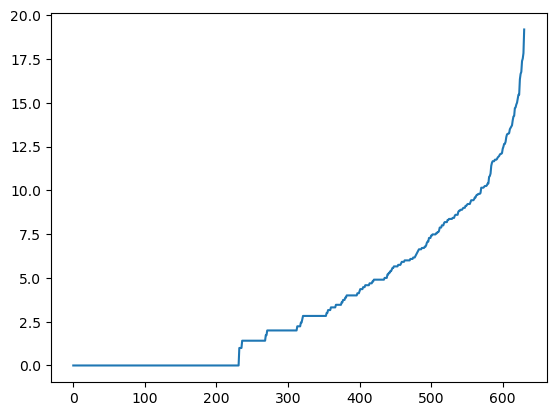

In [63]:
# Get the best eps value
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()



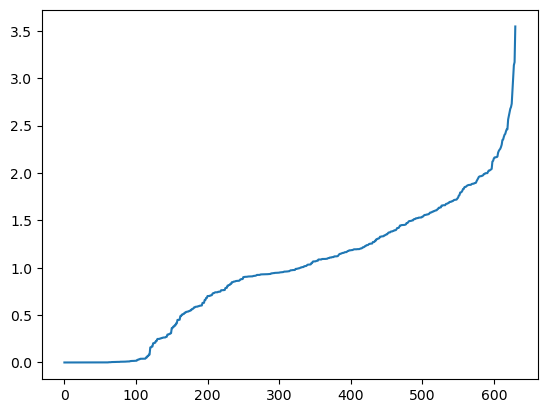

In [64]:
# Get the best eps value for tsne embedding
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_embedded)
distances, indices = nbrs.kneighbors(X_embedded)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [68]:
dbscan = DBSCAN(eps=2.5, min_samples=4).fit(X)
dbscan_results = dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: -0.0033378516567844985
Calinski Harabasz Score: 76.96509741190391
Davies Bouldin Score: 1.0943632415068745
Adjusted Rand Index: 0.14207509793331918


In [81]:
# Do for x_embedded
dbscan = DBSCAN(eps=1.2, min_samples=4).fit(X_embedded)
dbscan_results = dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , dbscan_results)}")

Silhouette Score: -0.4227396845817566
Calinski Harabasz Score: 14.932128414230736
Davies Bouldin Score: 1.4842988288641497
Adjusted Rand Index: 0.02043372743470436


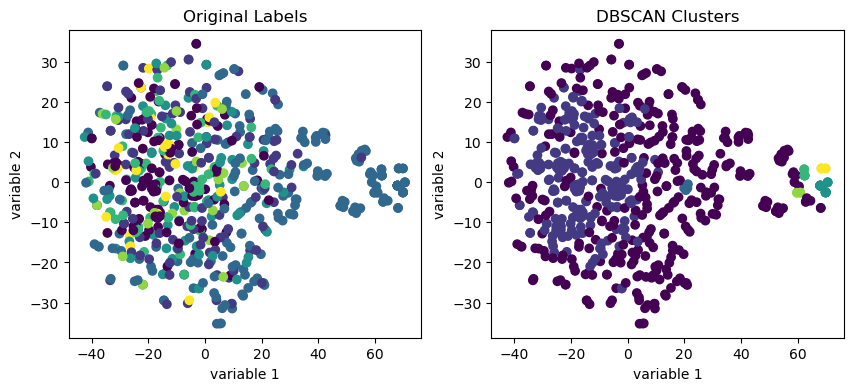

{0, 1, 2, 3, 4, 5, -1}


In [69]:
# Plot the clusters
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c = final_df['Label'], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Original Labels")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("DBSCAN Clusters")
plt.show()
print((set(dbscan_results)))

## Clustering Different Items (based on sub-category)

### K Means Clustering (K=3)

In [82]:
print("Number of unique labels: ", len(final_df2['Label'].unique()))

Number of unique labels:  3


In [83]:
X = final_df2.iloc[:, :-1]
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [84]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.12815351692563384
Calinski Harabasz Score: 1.6697014949776818
Davies Bouldin Score: 1.6414010837992088
Adjusted Rand Index: -0.09991809991809991


#### t-SNE

In [85]:
X_embedded = TSNE(n_components=2, init='pca', perplexity=4).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(17, 2)

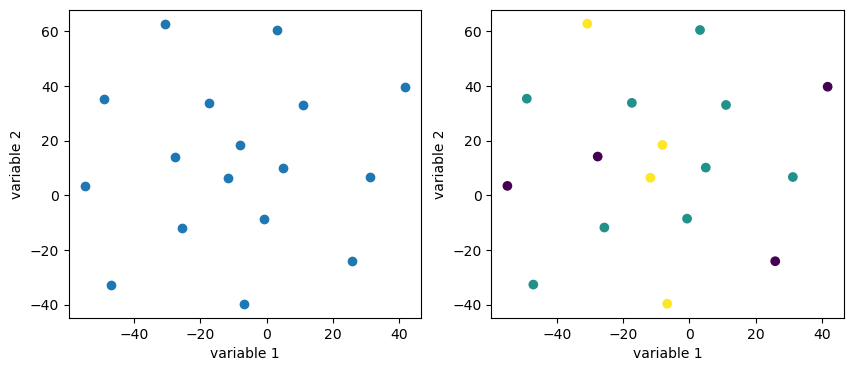

In [86]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df2['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [87]:
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [88]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.01785924466942454
Calinski Harabasz Score: 1.3063330923506666
Davies Bouldin Score: 2.828348309700068
Adjusted Rand Index: -0.11583011583011583


## Clustering using DBSCAN

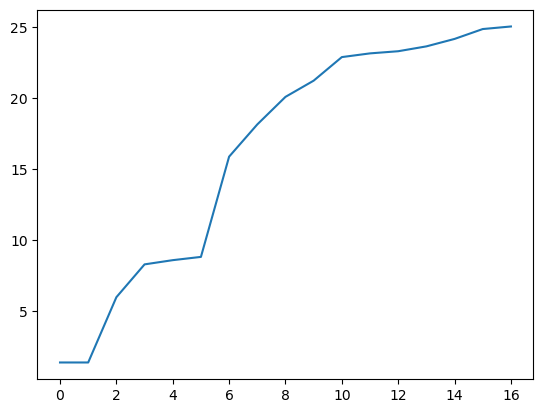

In [89]:
# Get the best eps value
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

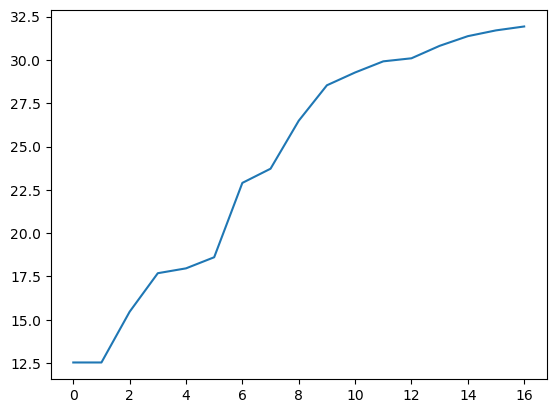

In [90]:
# Get the best eps value
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X_embedded)
distances, indices = nbrs.kneighbors(X_embedded)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [91]:
# eps = 0.5
dbscan = DBSCAN(eps=2, min_samples=2).fit(X)
dbscan_results = dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , dbscan_results)}")

Silhouette Score: -0.0997187645138408
Calinski Harabasz Score: 0.804058187648234
Davies Bouldin Score: 1.5302851064808922
Adjusted Rand Index: 0.1664190193164933


In [93]:
# Do the same for X_embedded
dbscan = DBSCAN(eps=14, min_samples=2).fit(X_embedded)
dbscan_results = dbscan.labels_

print(f"Silhouette Score: {silhouette_score(X_embedded, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X_embedded, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X_embedded, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , dbscan_results)}")

Silhouette Score: -0.20880086719989777
Calinski Harabasz Score: 0.0002793080483727284
Davies Bouldin Score: 86.13621543846709
Adjusted Rand Index: 0.1664190193164933


Text(0.5, 1.0, 'DBSCAN Clusters')

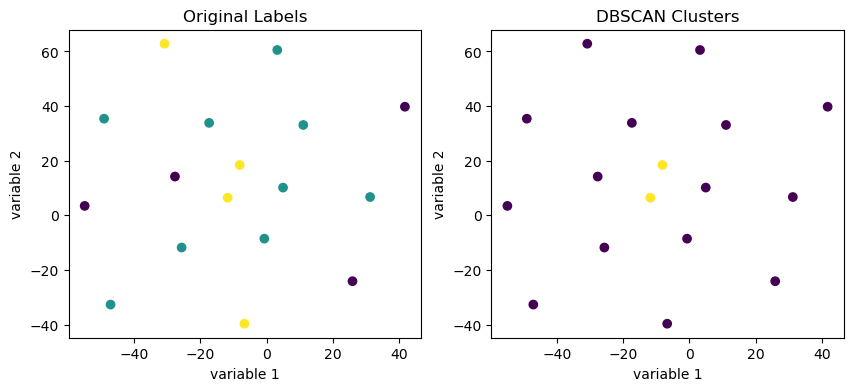

In [94]:
# Plot the clusters
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c = final_df2['Label'], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Original Labels")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=dbscan_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("DBSCAN Clusters")

# Using another dataset to cluster items

In [3]:
df_orders = pd.read_csv("../Dataset/instacart-market-basket-analysis/orders.csv")
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
# Count unique values in eval_set
df_orders['eval_set'].value_counts()


eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64

In [5]:
df_products = pd.read_csv("../Dataset/instacart-market-basket-analysis/products.csv")
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
print("Number of unique products: ", len(df_products['product_name'].unique()))

Number of unique products:  49688


In [7]:
# Aisle df
df_aisles = pd.read_csv("../Dataset/instacart-market-basket-analysis/aisles.csv")
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
# Department df
df_departments = pd.read_csv("../Dataset/instacart-market-basket-analysis/departments.csv")
df_departments.head()
# unique values
print("Number of unique aisles: ", len(df_aisles['aisle'].unique()))
print("Number of unique departments: ", len(df_departments['department'].unique()))

Number of unique aisles:  134
Number of unique departments:  21


In [9]:
df_orders_prior = pd.read_csv("../Dataset/instacart-market-basket-analysis/order_products__prior.csv")
df_orders_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [10]:
df_merged = df_orders_prior.merge(df_products, how='left', on='product_id')
df_merged.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [11]:
df_market_basket = df_merged.groupby(['order_id']).size().reset_index(name='count')
df_market_basket.head()

,order_id,count
0,2,9
1,3,8
2,4,13
3,5,26
4,6,3


In [12]:
#from mlxtend.frequent_patterns import apriori

# Convert df_merged into transactional format
transactional_data = df_merged.groupby(['order_id'])['product_name'].apply(list).reset_index(name='products')

# Apply Apriori algorithm
#frequent_itemsets = algorithm.apriori(transactional_data, min_support=0.001, use_colnames=True)

# Print the frequent itemsets
#print(frequent_itemsets)


In [13]:
transactional_data.head()

,order_id,products
0,2,"[Organic Egg Whites, Michigan Organic Kale, Ga..."
1,3,[Total 2% with Strawberry Lowfat Greek Straine...
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan,..."
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D..."


In [14]:
!python apriori.py

In [15]:
from apriori import TransactionEncoder

In [16]:
te = TransactionEncoder()
te_ary = te.fit(transactional_data['products']).transform(transactional_data['products'], sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
sparse_df.head()

,#2 Coffee Filters,#2 Cone White Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,'Swingtop' Premium Lager,(70% Juice!) Mountain Raspberry Juice Squeeze,+Energy Black Cherry Vegetable & Fruit Juice,".5\"" Waterproof Tape",0 Calorie Acai Raspberry Water Beverage,...,with Twist Ties Sandwich & Storage Bags,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Do the same above for aise and department
df_merged_aisle = df_merged.merge(df_aisles, how='left', on='aisle_id')
df_merged_aisle.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients


In [18]:
# Convert df_merged_aisle into transactional format
transactional_data_aisle = df_merged_aisle.groupby(['order_id'])['aisle'].apply(list).reset_index(name='aisles')

te = TransactionEncoder()
te_ary = te.fit(transactional_data_aisle['aisles']).transform(transactional_data_aisle['aisles'], sparse=True)
sparse_df_aisle = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
sparse_df_aisle.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Do the same above for department
df_merged_department = df_merged.merge(df_departments, how='left', on='department_id')
df_merged_department.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,Garlic Powder,104,13,pantry
3,2,45918,4,1,Coconut Butter,19,13,pantry
4,2,30035,5,0,Natural Sweetener,17,13,pantry


In [20]:
sparse_df_aisle

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3214872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Convert df_merged_department into transactional format
transactional_data_department = df_merged_department.groupby(['order_id'])['department'].apply(list)



In [22]:
transactional_data_department

order_id
2          [dairy eggs, produce, pantry, pantry, pantry, ...
3          [dairy eggs, dairy eggs, produce, produce, dai...
4          [bakery, personal care, snacks, breakfast, bre...
5          [produce, pantry, deli, produce, dairy eggs, h...
6                          [beverages, household, household]
                                 ...                        
3421079                                      [personal care]
3421080    [dairy eggs, frozen, beverages, produce, produ...
3421081    [snacks, bakery, pantry, dairy eggs, canned go...
3421082    [meat seafood, dairy eggs, produce, produce, d...
3421083    [snacks, babies, babies, babies, babies, house...
Name: department, Length: 3214874, dtype: object

In [23]:
te = TransactionEncoder()
te_ary = te.fit(transactional_data_department).transform(transactional_data_department, sparse=True)
sparse_df_department = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_, index=transactional_data_department.index)
sparse_df_department.head()

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,1,0,0,0,1,1,1,...,1,1,1,0,0,1,1,0,1,1
6,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
sparse_df_department

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,1,0,0,0,1,1,1,...,1,1,1,0,0,1,1,0,1,1
6,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3421080,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3421081,0,0,1,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,1


In [25]:
# Apply Apriori algorithm on sparse_df_aisle
#frequent_itemsets_aisle = algorithm.apriori(sparse_df_aisle, min_support=0.001, use_colnames=True)
# Random sample of 1000 rows
algorithm = Apriori()
sample = sparse_df_department.sample(n=10000, random_state=1)
frequent_itemsets_department = algorithm.apriori(df=sample, use_colnames=True, verbose=1, count=False, min_support=0.2)
# Print the frequent itemsets
print(frequent_itemsets_department)

Processing 12 combinations | Sampling itemset size 4
    support                          itemsets
0    0.2670                          (bakery)
1    0.4487                       (beverages)
2    0.2090                    (canned goods)
3    0.6843                      (dairy eggs)
4    0.2353                            (deli)
5    0.3667                          (frozen)
6    0.3515                          (pantry)
7    0.7518                         (produce)
8    0.4246                          (snacks)
9    0.2193              (dairy eggs, bakery)
10   0.2231                 (bakery, produce)
11   0.3207           (dairy eggs, beverages)
12   0.3321              (produce, beverages)
13   0.2235               (snacks, beverages)
14   0.2825              (frozen, dairy eggs)
15   0.2735              (dairy eggs, pantry)
16   0.5588             (dairy eggs, produce)
17   0.3158              (dairy eggs, snacks)
18   0.2014                   (deli, produce)
19   0.2987                

In [44]:
sample_aisle = sparse_df_aisle.sample(n=10000, random_state=1)
frequent_itemsets_aisle = algorithm.apriori(df=sample_aisle, use_colnames=True, verbose=1, count=False, min_support=0.1)
# Print the frequent itemsets
print(frequent_itemsets_aisle)

Processing 24 combinations | Sampling itemset size 43
    support                                           itemsets
0    0.1571                                            (bread)
1    0.1656                                   (chips pretzels)
2    0.1119                                         (crackers)
3    0.1402                                             (eggs)
4    0.5623                                     (fresh fruits)
5    0.4520                                 (fresh vegetables)
6    0.1229                                   (frozen produce)
7    0.1105                                    (ice cream ice)
8    0.1020                                       (lunch meat)
9    0.2441                                             (milk)
10   0.2285                                  (packaged cheese)
11   0.3663                       (packaged vegetables fruits)
12   0.1290                                     (refrigerated)
13   0.1741                                  (soy lactosefree)
1

In [27]:
# Convert frequent_itemsets_aisle into a DataFrame with frequent itemsets as features
new_df = pd.DataFrame(index=sparse_df_department.columns)
new_col = frequent_itemsets_department['itemsets'].tolist()
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for item in sparse_df_department.columns:
        if item not in itemset:
            new_df.at[item, itemset] = 0

100%|██████████| 26/26 [00:00<00:00, 1274.95it/s]


In [28]:
# Convert frequent_itemsets_aisle_2 into a DataFrame with frequent itemsets as features
new_df_2 = pd.DataFrame(index=sparse_df_aisle.columns)
new_col_2 = frequent_itemsets_aisle['itemsets'].tolist()
new_df_2[new_col_2] = 1
for itemset in tqdm(new_col_2):
    for item in sparse_df_aisle.columns:
        if item not in itemset:
            new_df_2.at[item, itemset] = 0

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 298.41it/s]


In [29]:
new_df.head()

,(bakery),(beverages),(canned goods),(dairy eggs),(deli),(frozen),(pantry),(produce),(snacks),"(dairy eggs, bakery)",...,"(dairy eggs, produce)","(dairy eggs, snacks)","(deli, produce)","(frozen, produce)","(pantry, produce)","(snacks, produce)","(dairy eggs, produce, beverages)","(frozen, produce, dairy eggs)","(dairy eggs, pantry, produce)","(dairy eggs, snacks, produce)"
alcohol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
babies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bakery,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
beverages,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
breakfast,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
new_df_2.head()

,(bread),(chips pretzels),(crackers),(eggs),(fresh fruits),(fresh vegetables),(frozen produce),(ice cream ice),(lunch meat),(milk),...,"(fresh vegetables, packaged vegetables fruits)","(yogurt, fresh vegetables)","(milk, packaged vegetables fruits)","(packaged vegetables fruits, packaged cheese)","(yogurt, packaged vegetables fruits)","(fresh fruits, milk, fresh vegetables)","(fresh fruits, fresh vegetables, packaged cheese)","(fresh fruits, packaged vegetables fruits, fresh vegetables)","(fresh fruits, yogurt, fresh vegetables)","(fresh fruits, yogurt, packaged vegetables fruits)"
air fresheners candles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
asian foods,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baby accessories,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baby bath body care,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baby food formula,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
itemset_set = set(frequent_itemsets_department['itemsets'].tolist())
new_df = sample.apply(lambda row: [int(itemset.issubset(set(row.index[row.astype(bool)]))) for itemset in itemset_set], axis=1)
new_df = pd.DataFrame(new_df.tolist(), columns=list(itemset_set), index=sample.index)
new_df.head()

,(snacks),(produce),(frozen),"(frozen, produce)","(dairy eggs, snacks, produce)",(bakery),"(bakery, produce)","(dairy eggs, produce, beverages)","(produce, beverages)",(canned goods),...,"(pantry, produce)","(dairy eggs, pantry, produce)","(frozen, produce, dairy eggs)","(dairy eggs, snacks)","(dairy eggs, produce)","(frozen, dairy eggs)","(dairy eggs, pantry)","(snacks, beverages)",(dairy eggs),"(snacks, produce)"
order_id,,,,,,,,,,,,,,,,,,,,,
2513124,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
551298,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165311,1,1,0,0,1,1,1,1,1,0,...,0,0,0,1,1,0,0,1,1,1
76294,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
90358,0,1,0,0,0,1,1,1,1,0,...,1,1,0,0,1,0,1,0,1,0


In [48]:
itemset_set_aise = set(frequent_itemsets_aisle['itemsets'].tolist())
new_df_aisle = sample_aisle.apply(lambda row: [int(itemset.issubset(set(row.index[row.astype(bool)]))) for itemset in itemset_set_aise], axis=1)
new_df_aisle = pd.DataFrame(new_df_aisle.tolist(), columns=list(itemset_set_aise), index=sample_aisle.index)
new_df_aisle.head()

,(refrigerated),"(fresh fruits, milk)","(packaged vegetables fruits, packaged cheese)","(fresh fruits, packaged cheese)",(packaged vegetables fruits),"(milk, fresh vegetables)","(fresh fruits, yogurt)","(fresh fruits, fresh vegetables)","(fresh fruits, yogurt, fresh vegetables)","(fresh fruits, chips pretzels)",...,(eggs),"(fresh fruits, soy lactosefree)","(fresh fruits, yogurt, packaged vegetables fruits)","(fresh fruits, packaged vegetables fruits, fresh vegetables)","(yogurt, fresh vegetables)",(packaged cheese),(milk),(soy lactosefree),(yogurt),"(yogurt, packaged vegetables fruits)"
2361521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
517777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155276,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
71644,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
84869,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


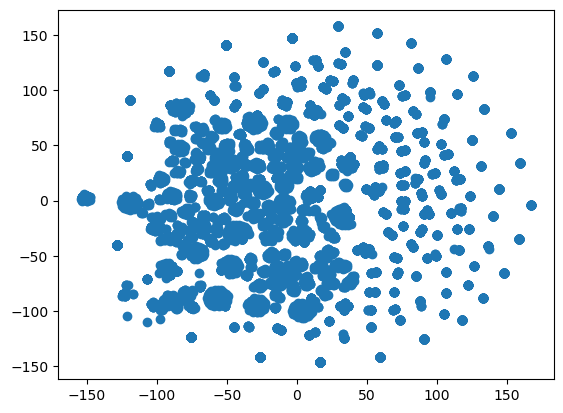

In [49]:
# Show the rows in a scatter plot
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(new_df)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

plt.scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')

In [126]:
''' KEEPS CRASHING ''' 
'''
# Plot the same for aisle
X_embedded_aisle = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(new_df_aisle)
X_embedded_aisle = pd.DataFrame(X_embedded_aisle)
X_embedded_aisle.shape

plt.scatter(x=X_embedded_aisle.iloc[:, 0], y=X_embedded_aisle.iloc[:, 1], cmap='viridis')
'''

: 

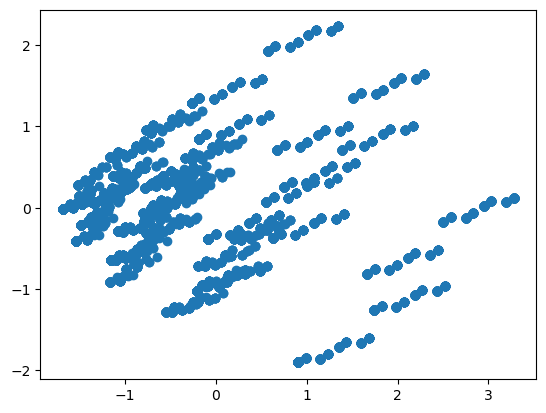

In [50]:
# Do the same with pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(new_df)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

plt.scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')

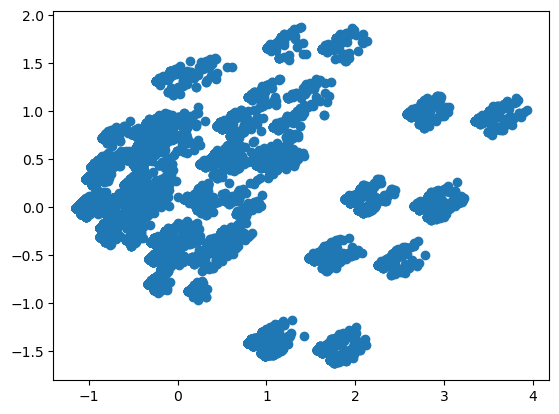

In [51]:
# Do the same using pca for aisle
pca = PCA(n_components=2)
X_embedded_aisle = pca.fit_transform(new_df_aisle)
X_embedded_aisle = pd.DataFrame(X_embedded_aisle)
X_embedded_aisle.shape

plt.scatter(x=X_embedded_aisle.iloc[:, 0], y=X_embedded_aisle.iloc[:, 1], cmap='viridis')

In [52]:
# Add order hour of day to the new_df on new_df index and df_orders order_id
new_df = new_df.merge(df_orders[['order_id', 'order_hour_of_day']], how='left', left_index=True, right_on='order_id').set_index('order_id')
new_df.head()

,(snacks),(produce),(frozen),"(frozen, produce)","(dairy eggs, snacks, produce)",(bakery),"(bakery, produce)","(dairy eggs, produce, beverages)","(produce, beverages)",(canned goods),...,"(dairy eggs, pantry, produce)","(frozen, produce, dairy eggs)","(dairy eggs, snacks)","(dairy eggs, produce)","(frozen, dairy eggs)","(dairy eggs, pantry)","(snacks, beverages)",(dairy eggs),"(snacks, produce)",order_hour_of_day
order_id,,,,,,,,,,,,,,,,,,,,,
2513124,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20
551298,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
165311,1,1,0,0,1,1,1,1,1,0,...,0,0,1,1,0,0,1,1,1,12
76294,0,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,22
90358,0,1,0,0,0,1,1,1,1,0,...,1,0,0,1,0,1,0,1,0,17


In [53]:
# Do the same for aisle
new_df_aisle = new_df_aisle.merge(df_orders[['order_id', 'order_hour_of_day']], how='left', left_index=True, right_on='order_id').set_index('order_id')
new_df_aisle.head()

,(refrigerated),"(fresh fruits, milk)","(packaged vegetables fruits, packaged cheese)","(fresh fruits, packaged cheese)",(packaged vegetables fruits),"(milk, fresh vegetables)","(fresh fruits, yogurt)","(fresh fruits, fresh vegetables)","(fresh fruits, yogurt, fresh vegetables)","(fresh fruits, chips pretzels)",...,"(fresh fruits, soy lactosefree)","(fresh fruits, yogurt, packaged vegetables fruits)","(fresh fruits, packaged vegetables fruits, fresh vegetables)","(yogurt, fresh vegetables)",(packaged cheese),(milk),(soy lactosefree),(yogurt),"(yogurt, packaged vegetables fruits)",order_hour_of_day
order_id,,,,,,,,,,,,,,,,,,,,,
2361521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
517777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
155276,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,7
71644,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,21
84869,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,15


In [54]:
new_df['order_hour_of_day'].value_counts()

order_hour_of_day
13    869
14    863
15    854
10    837
11    784
16    782
12    780
9     763
17    670
18    534
8     512
19    393
20    294
7     254
21    231
22    194
23    124
6      96
0      63
2      31
5      25
1      25
3      12
4      10
Name: count, dtype: int64

## Cluster using hour of day

Text(0.5, 1.0, 'KMeans Clusters')

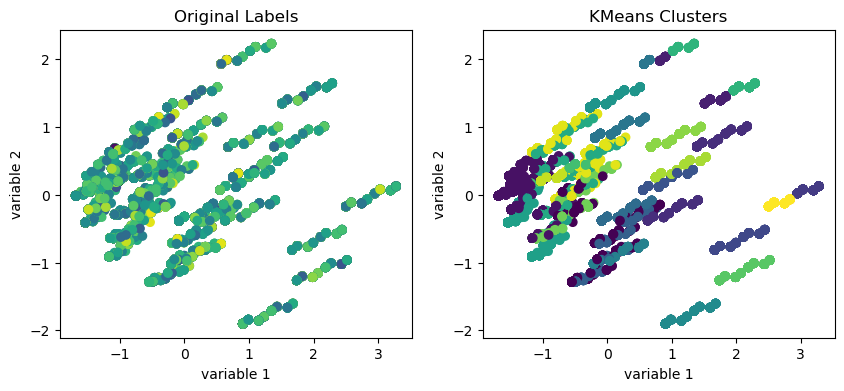

In [55]:
# Create 24 clusters
from sklearn.cluster import KMeans

X = new_df.iloc[:, :-1]
kmeans = KMeans(n_clusters=24, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Show the clusters in a scatter plot with true and predicted labels side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c= new_df['order_hour_of_day'] , cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Original Labels")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("KMeans Clusters")

In [56]:
# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")

# Calculate the calinski harabasz score
from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")

# Calculate the davies bouldin score
from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")

# Calculate the adjusted rand index
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day'] , kmeans_results)}")

Silhouette Score: 0.3233916710680028
Calinski Harabasz Score: 1175.952745019389
Davies Bouldin Score: 1.2964063670992034
Adjusted Rand Index: 0.0013704081641151352


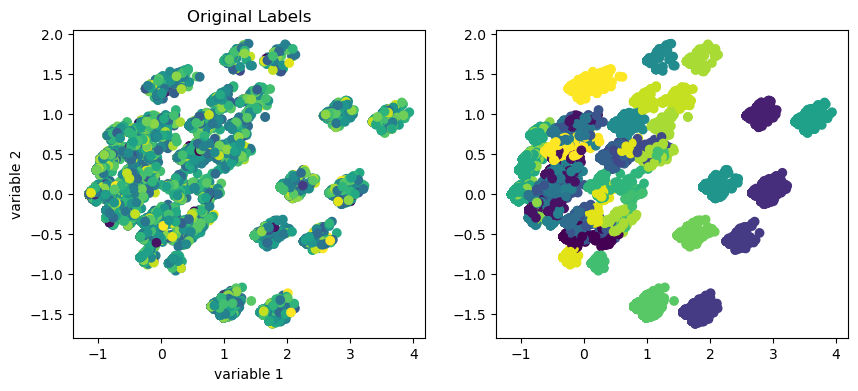

In [57]:
# Create 24 clusters for aisle
from sklearn.cluster import KMeans

X = new_df_aisle.iloc[:, :-1]
kmeans = KMeans(n_clusters=24, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Show the clusters in a scatter plot with true and predicted labels side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded_aisle.iloc[:, 0], y=X_embedded_aisle.iloc[:, 1], c= new_df_aisle['order_hour_of_day'] , cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("Original Labels")
axes[1].scatter(x=X_embedded_aisle.iloc[:, 0], y=X_embedded_aisle.iloc[:, 1], c=kmeans_results, cmap='viridis')

In [58]:
# Do the same for aisle
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(new_df_aisle['order_hour_of_day'] , kmeans_results)}")

Silhouette Score: 0.20952598526606803
Calinski Harabasz Score: 664.4762711746265
Davies Bouldin Score: 1.6930068843955455
Adjusted Rand Index: 9.654318425084867e-05


## Cluster using hour of day grouping

In [59]:
# Lets create a mapping of the hours into 4 categories
# 0-6: Night
# 6-12: Morning
# 12-18: Afternoon
# 18-24: Evening

new_df['order_hour_of_day'].value_counts()

new_df['order_hour_of_day_grouping'] = new_df['order_hour_of_day'].apply(lambda x: 0 if x<6 else (1 if x<12 else (2 if x<18 else 3)))

new_df['order_hour_of_day_grouping'].value_counts()

# Create 4 clusters
from sklearn.cluster import KMeans

X = new_df.iloc[:, :-2]
kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")

# Calculate the calinski harabasz score
from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")

# Calculate the davies bouldin score
from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")

# Calculate the adjusted rand index
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day_grouping'] , kmeans_results)}")




Silhouette Score: 0.24037603733083096
Calinski Harabasz Score: 1906.2525372592834
Davies Bouldin Score: 1.7547053776518957
Adjusted Rand Index: 0.002609208566414797


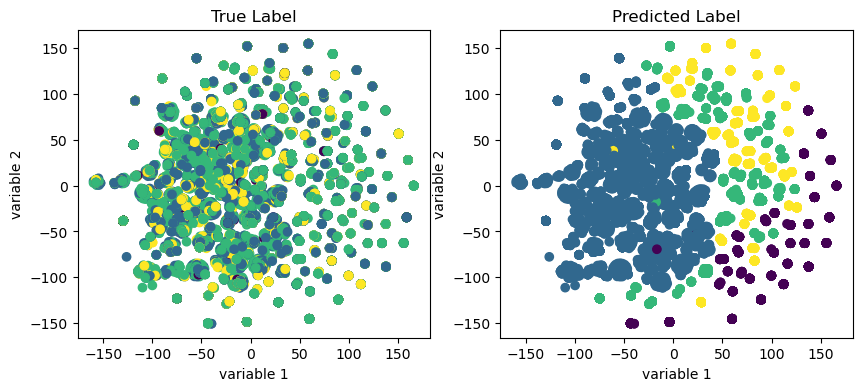

In [60]:
# Scatter plot using tsne
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

# Plot two graphs, one using true label and one using predicted label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=new_df['order_hour_of_day_grouping'] ,cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("True Label")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Predicted Label")

plt.show()


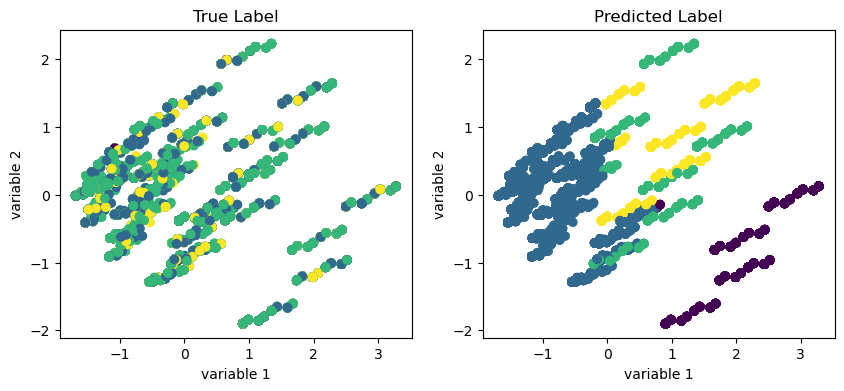

In [61]:
# Scatter plot using pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

# Plot two graphs, one using true label and one using predicted label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=new_df['order_hour_of_day_grouping'] ,cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("True Label")

axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Predicted Label")

plt.show()

In [62]:
# Do the same for aisle
new_df_aisle['order_hour_of_day'].value_counts()

new_df_aisle['order_hour_of_day_grouping'] = new_df_aisle['order_hour_of_day'].apply(lambda x: 0 if x<6 else (1 if x<12 else (2 if x<18 else 3)))

new_df_aisle['order_hour_of_day_grouping'].value_counts()

# Create 4 clusters
from sklearn.cluster import KMeans

X = new_df_aisle.iloc[:, :-2]
kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(new_df_aisle['order_hour_of_day_grouping'] , kmeans_results)}")

Silhouette Score: 0.1904810546035334
Calinski Harabasz Score: 1441.5467935811703
Davies Bouldin Score: 2.3362536301509387
Adjusted Rand Index: -0.00448277024946096


## Cluster using DBSCAN

In [72]:
new_df

,(snacks),(produce),(frozen),"(frozen, produce)","(dairy eggs, snacks, produce)",(bakery),"(bakery, produce)","(dairy eggs, produce, beverages)","(produce, beverages)",(canned goods),...,"(frozen, produce, dairy eggs)","(dairy eggs, snacks)","(dairy eggs, produce)","(frozen, dairy eggs)","(dairy eggs, pantry)","(snacks, beverages)",(dairy eggs),"(snacks, produce)",order_hour_of_day,order_hour_of_day_grouping
order_id,,,,,,,,,,,,,,,,,,,,,
2513124,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,20,3
551298,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,1
165311,1,1,0,0,1,1,1,1,1,0,...,0,1,1,0,0,1,1,1,12,2
76294,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,22,3
90358,0,1,0,0,0,1,1,1,1,0,...,0,0,1,0,1,0,1,0,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361130,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,11,1
2241752,0,1,1,1,0,0,0,1,1,0,...,1,0,1,1,1,0,1,0,14,2
2341897,1,1,0,0,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,16,2


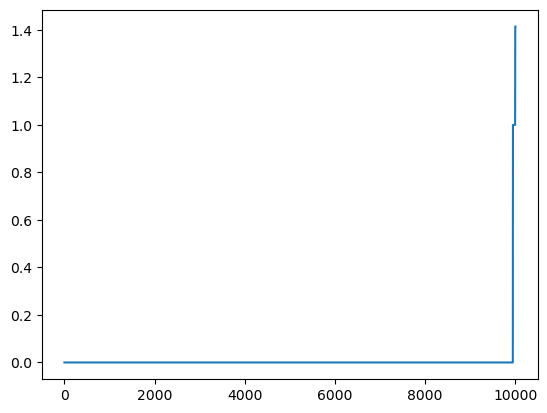

In [69]:
# get the best eps value for dbscan on department
X = new_df.iloc[:, :-2]


from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5000)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

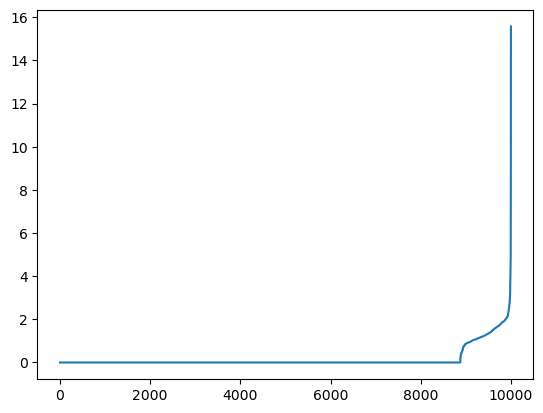

In [70]:
X_embedded = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_embedded)
distances, indices = nbrs.kneighbors(X_embedded)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [87]:
# Use DBSCAN to cluster the data
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=10).fit(X_embedded)
dbscan_results = dbscan.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day_grouping'] , dbscan_results)}")

Silhouette Score: 0.27548434656788934
Calinski Harabasz Score: 148.77201776785682
Davies Bouldin Score: 0.8582974784022077
Adjusted Rand Index: 0.004287956276901576


## USING a support score smaller than before

In [90]:
# reduce the number of frequent itemsets
# Use frequent_itemsets on sparse_df_department

# Apply Apriori algorithm on sparse_df_aisle
#frequent_itemsets_aisle = algorithm.apriori(sparse_df_aisle, min_support=0.001, use_colnames=True)
# Random sample of 1000 rows
algorithm = Apriori()
sample = sparse_df_department.sample(n=10000, random_state=1)
frequent_itemsets_department = algorithm.apriori(df=sample, use_colnames=True, verbose=1, count=False, min_support=0.1)
# Print the frequent itemsets
print(frequent_itemsets_department)

Processing 20 combinations | Sampling itemset size 54
     support                                  itemsets
0     0.2670                                  (bakery)
1     0.4487                               (beverages)
2     0.1625                               (breakfast)
3     0.2090                            (canned goods)
4     0.6843                              (dairy eggs)
..       ...                                       ...
97    0.1461  (dairy eggs, snacks, produce, beverages)
98    0.1032       (dairy eggs, snacks, deli, produce)
99    0.1188     (frozen, pantry, produce, dairy eggs)
100   0.1356     (frozen, snacks, produce, dairy eggs)
101   0.1272     (dairy eggs, pantry, snacks, produce)

[102 rows x 2 columns]


In [106]:
itemset_set = set(frequent_itemsets_department['itemsets'].tolist())
new_df = sample.apply(lambda row: [int(itemset.issubset(set(row.index[row.astype(bool)]))) for itemset in itemset_set], axis=1)
new_df = pd.DataFrame(new_df.tolist(), columns=list(itemset_set), index=sample.index)
new_df.head()

,"(dairy eggs, snacks, deli)",(produce),"(dairy eggs, pantry, beverages)","(frozen, pantry, produce)","(dairy eggs, pantry, produce, beverages)","(produce, breakfast)","(produce, household)","(dairy eggs, produce, beverages)","(frozen, pantry, produce, dairy eggs)","(bakery, beverages)",...,"(pantry, canned goods)","(frozen, snacks, dairy eggs)","(dairy eggs, beverages)","(snacks, produce, beverages)","(dairy eggs, snacks, produce, beverages)","(pantry, beverages)","(dairy eggs, produce)","(dairy eggs, snacks, bakery)","(frozen, beverages)","(snacks, produce)"
order_id,,,,,,,,,,,,,,,,,,,,,
2513124,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
551298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165311,1,1,0,0,0,0,0,1,0,1,...,0,0,1,1,1,0,1,1,0,1
76294,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
90358,0,1,1,0,1,0,0,1,0,1,...,0,0,1,0,0,1,1,0,0,0


In [107]:
# Add order hour of day to the new_df on new_df index and df_orders order_id
new_df = new_df.merge(df_orders[['order_id', 'order_hour_of_day']], how='left', left_index=True, right_on='order_id').set_index('order_id')
new_df.head()

# Create 24 clusters

X = new_df.iloc[:, :-1]
kmeans = KMeans(n_clusters=24, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_



# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")

# Calculate the calinski harabasz score

from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")

# Calculate the davies bouldin score

from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")

# Calculate the adjusted rand index

from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day'] , kmeans_results)}")

Silhouette Score: 0.1517353578399691
Calinski Harabasz Score: 538.3897180645475
Davies Bouldin Score: 1.8143840147789938
Adjusted Rand Index: 0.0013384068962052444


Text(0.5, 1.0, 'Predicted Label')

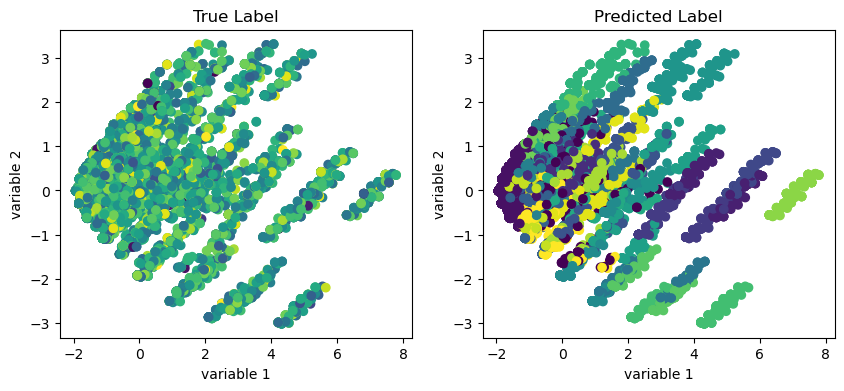

In [108]:
# Use pca and then plot side by side

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

# Plot two graphs, one using true label and one using predicted label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=new_df['order_hour_of_day'] ,cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("True Label")

axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Predicted Label")

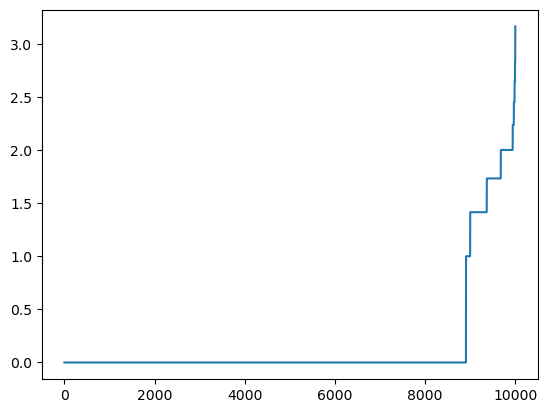

In [110]:
# get the best eps value for dbscan on department
X = new_df.iloc[:, :-1]


from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5000)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

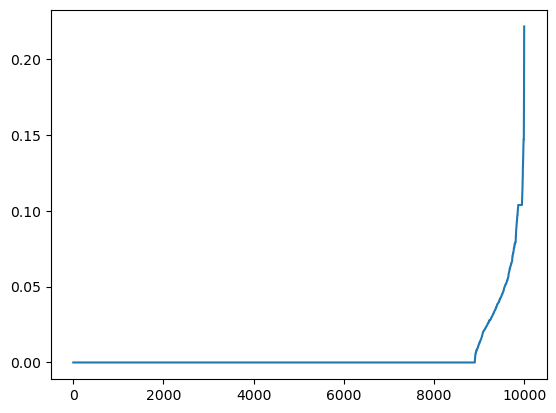

In [111]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5000)
nbrs = neigh.fit(X_embedded)
distances, indices = nbrs.kneighbors(X_embedded)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [119]:
# Use DBSCAN to cluster the data
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.0005, min_samples=4).fit(X_embedded)
dbscan_results = dbscan.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day'] , dbscan_results)}")

Silhouette Score: 0.5715579204532207
Calinski Harabasz Score: 29.00013770094263
Davies Bouldin Score: 1.1065392031076366
Adjusted Rand Index: 0.0012569308131485002


In [120]:
# Lets create a mapping of the hours into 4 categories
# 0-6: Night
# 7-12: Morning
# 13-18: Afternoon
# 19-23: Evening

# Use that grouping to form new labels and perform clustering again
new_df['order_hour_of_day_grouped'] = new_df['order_hour_of_day'].apply(lambda x: 0 if x<=6 else 1 if x<=12 else 2 if x<=18 else 3)
print(new_df.head())

# Create 4 clusters
from sklearn.cluster import KMeans

X = new_df.iloc[:, :-2]
kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")

# Calculate the calinski harabasz score
from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")

# Calculate the davies bouldin score
from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")

# Calculate the adjusted rand index
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day_grouped'] , kmeans_results)}")


          (dairy eggs, snacks, deli)  (produce)  \
order_id                                          
2513124                            0          1   
551298                             0          0   
165311                             1          1   
76294                              0          1   
90358                              0          1   

          (dairy eggs, pantry, beverages)  (frozen, pantry, produce)  \
order_id                                                               
2513124                                 0                          0   
551298                                  0                          0   
165311                                  0                          0   
76294                                   0                          0   
90358                                   1                          0   

          (dairy eggs, pantry, produce, beverages)  (produce, breakfast)  \
order_id                                                     

Text(0.5, 1.0, 'Predicted Label')

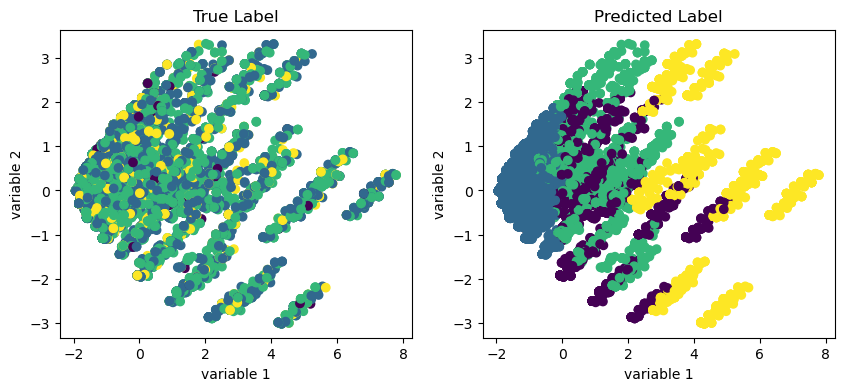

In [121]:
# Scatter plot using pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

# Plot two graphs, one using true label and one using predicted label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=new_df['order_hour_of_day_grouped'] ,cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[0].set_title("True Label")

axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=kmeans_results, cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
axes[1].set_title("Predicted Label")


In [124]:
# Use DBSCAN to cluster the data
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.0005, min_samples=4).fit(X_embedded)
dbscan_results = dbscan.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, dbscan_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, dbscan_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, dbscan_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day_grouped'] , dbscan_results)}")

Silhouette Score: 0.5715579204532207
Calinski Harabasz Score: 29.00013770094263
Davies Bouldin Score: 1.1065392031076366
Adjusted Rand Index: 0.0003116713959946291


In [145]:
# Add user_id to the new_df on new_df index and df_orders order_id

new_df_user = new_df.merge(df_orders[['order_id', 'user_id']], how='left', left_index=True, right_on='order_id').set_index('order_id')
new_df_user.head()

# Get number of unique users
len(new_df_user['user_id'].unique())




9503

In [146]:
new_df_user['user_id'].value_counts()

user_id
118129    4
52962     3
11661     3
75805     3
5296      3
         ..
108390    1
51631     1
74886     1
62239     1
115113    1
Name: count, Length: 9503, dtype: int64

In [148]:
# Create 9503 clusters
from sklearn.cluster import KMeans

X = new_df_user.iloc[:, :-3]
kmeans = KMeans(n_clusters=9503, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
# Calculate the calinski harabasz score
from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
# Calculate the davies bouldin score
from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
# Calculate the adjusted rand index
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df_user['user_id'] , kmeans_results)}")

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/Users/parkhiagarwal/opt/anaconda3/envs/dataProducts/lib/python3.9/site-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/Users/parkhiagarwal/opt/anaconda3/envs/dataProducts/lib/python3.9/site-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

## Miscalenous (If I group by user then multiple orders are clubbed together which is not what I want since I want to cluster users based on their orders) 

In [128]:
# Do the same as above but use user id for grouping
df_merged_user = df_merged.merge(df_orders, how='left', on='order_id')

# merge with department
df_merged_user = df_merged_user.merge(df_departments, how='left', on='department_id')
df_merged_user.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,pantry


In [129]:
# Convert df_merged_user into transactional format
transactional_data_user = df_merged_user.groupby(['user_id'])['department'].apply(list)

te = TransactionEncoder()
te_ary = te.fit(transactional_data_user).transform(transactional_data_user, sparse=True)
sparse_df_user = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_, index=transactional_data_user.index)
sparse_df_user.head()

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,True,True
2,0,0,1,1,1,0,1,1,1,0,...,0,1,1,0,0,1,1,0,True,True
3,0,0,0,1,0,0,0,1,1,1,...,1,0,0,0,0,1,0,0,True,True
4,1,0,1,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,True,True
5,0,0,0,0,0,0,1,1,1,1,...,0,1,0,0,0,1,0,0,True,True


In [130]:
sparse_df_user.shape

(206209, 21)

In [105]:
sparse_df_user.columns

Index(['alcohol', 'babies', 'bakery', 'beverages', 'breakfast', 'bulk',
       'canned goods', 'dairy eggs', 'deli', 'dry goods pasta', 'frozen',
       'household', 'international', 'meat seafood', 'missing', 'other',
       'pantry', 'personal care', 'pets', 'produce', 'snacks'],
      dtype='object')

In [131]:

# Apply Apriori algorithm on sparse_df_user
#frequent_itemsets_user = algorithm.apriori(sparse_df_user, min_support=0.001, use_colnames=True)
# Random sample of 1000 rows
algorithm = Apriori()
sample = sparse_df_user.sample(n=10000, random_state=1)
frequent_itemsets_user = algorithm.apriori(df=sample, use_colnames=True, verbose=1, count=False, min_support=0.7)

# Print the frequent itemsets
print(frequent_itemsets_user)


Processing 24 combinations | Sampling itemset size 4
    support                               itemsets
0    0.8360                            (beverages)
1    0.9250                           (dairy eggs)
2    0.7954                               (frozen)
3    0.8374                               (pantry)
4    0.9381                              (produce)
5    0.8448                               (snacks)
6    0.7880                (dairy eggs, beverages)
7    0.7242                    (pantry, beverages)
8    0.7897                   (beverages, produce)
9    0.7350                    (snacks, beverages)
10   0.7658                   (dairy eggs, frozen)
11   0.8068                   (pantry, dairy eggs)
12   0.8881                  (dairy eggs, produce)
13   0.8005                   (snacks, dairy eggs)
14   0.7115                       (pantry, frozen)
15   0.7682                      (produce, frozen)
16   0.7056                       (snacks, frozen)
17   0.8087                  

In [132]:
# Use frequent_itemsets on sparse_df_user
new_df = pd.DataFrame(index=sample.index)
new_col = frequent_itemsets_user['itemsets'].tolist()
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sample.index:
        for item in itemset:
            if sample.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

new_df.head()




100%|██████████| 31/31 [05:58<00:00, 11.56s/it]


,(beverages),(dairy eggs),(frozen),(pantry),(produce),(snacks),"(dairy eggs, beverages)","(pantry, beverages)","(beverages, produce)","(snacks, beverages)",...,"(beverages, dairy eggs, produce)","(snacks, dairy eggs, beverages)","(beverages, pantry, produce)","(beverages, snacks, produce)","(dairy eggs, produce, frozen)","(pantry, dairy eggs, produce)","(pantry, snacks, dairy eggs)","(snacks, dairy eggs, produce)","(pantry, snacks, produce)","(pantry, snacks, dairy eggs, produce)"
user_id,,,,,,,,,,,,,,,,,,,,,
110192,1,1,1,0,1,1,1,0,1,1,...,1,1,0,1,1,0,0,1,0,0
33116,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
115998,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
183157,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
86976,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [133]:
# Add order hour of day to the new_df on new_df index and df_orders order_id
new_df = new_df.merge(df_orders[['user_id', 'order_hour_of_day']], how='left', left_index=True, right_on='user_id').set_index('user_id')
new_df.head()


,(beverages),(dairy eggs),(frozen),(pantry),(produce),(snacks),"(dairy eggs, beverages)","(pantry, beverages)","(beverages, produce)","(snacks, beverages)",...,"(snacks, dairy eggs, beverages)","(beverages, pantry, produce)","(beverages, snacks, produce)","(dairy eggs, produce, frozen)","(pantry, dairy eggs, produce)","(pantry, snacks, dairy eggs)","(snacks, dairy eggs, produce)","(pantry, snacks, produce)","(pantry, snacks, dairy eggs, produce)",order_hour_of_day
user_id,,,,,,,,,,,,,,,,,,,,,
110192,1,1,1,0,1,1,1,0,1,1,...,1,0,1,1,0,0,1,0,0,11
110192,1,1,1,0,1,1,1,0,1,1,...,1,0,1,1,0,0,1,0,0,13
110192,1,1,1,0,1,1,1,0,1,1,...,1,0,1,1,0,0,1,0,0,20
110192,1,1,1,0,1,1,1,0,1,1,...,1,0,1,1,0,0,1,0,0,20
33116,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,13


In [ ]:

# Create 24 clusters
from sklearn.cluster import KMeans

X = new_df.iloc[:, :-1]
kmeans = KMeans(n_clusters=24, random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

# Calculate the silhouette score
from sklearn.metrics import silhouette_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")

# Calculate the calinski harabasz score
from sklearn.metrics import calinski_harabasz_score

print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")

# Calculate the davies bouldin score
from sklearn.metrics import davies_bouldin_score

print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")

# Calculate the adjusted rand index
from sklearn.metrics import adjusted_rand_score

print(f"Adjusted Rand Index: {adjusted_rand_score(new_df['order_hour_of_day'] , kmeans_results)}")

In [45]:
sample = sparse_df.sample(n=10000, random_state=1)
# Apply Apriori algorithm on sparse_df_aisle
#frequent_itemsets_aisle = algorithm.apriori(sparse_df_aisle, min_support=0.001, use_colnames=True)
# Random sample of 1000 rows
algorithm = Apriori()
frequent_itemsets_product = algorithm.apriori(df=sample, use_colnames=True, verbose=1, count=False, min_support=0.02)
# Print the frequent itemsets
print(frequent_itemsets_product)

Processing 1640 combinations | Sampling itemset size 2
    support                                        itemsets
0    0.0266                      (Apple Honeycrisp Organic)
1    0.1224                        (Bag of Organic Bananas)
2    0.1471                                        (Banana)
3    0.0213                                       (Carrots)
4    0.0328                                (Cucumber Kirby)
5    0.0230                             (Fresh Cauliflower)
6    0.0200                             (Green Bell Pepper)
7    0.0219                                   (Half & Half)
8    0.0251                              (Honeycrisp Apple)
9    0.0463                                   (Large Lemon)
10   0.0440                                         (Limes)
11   0.0200                         (Michigan Organic Kale)
12   0.0551                               (Organic Avocado)
13   0.0237                          (Organic Baby Arugula)
14   0.0240                          (Organic

In [49]:
new_df = pd.DataFrame(index=sample.columns)
new_col = frequent_itemsets_product['itemsets'].tolist()
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for item in sample.columns:
        if item not in itemset:
            new_df.at[item, itemset] = 0

100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


In [54]:
new_df.index.name = 'product_name'

In [56]:
final_df2 = new_df.merge(df_products[['product_name', 'department_id']], how='left', on='product_name').set_index('product_name')
final_df2.rename(columns={"department_id": "Label"}, inplace=True)

In [64]:
print(final_df2.shape)
final_df2.head()

(49677, 43)


,(Apple Honeycrisp Organic),(Bag of Organic Bananas),(Banana),(Carrots),(Cucumber Kirby),(Fresh Cauliflower),(Green Bell Pepper),(Half & Half),(Honeycrisp Apple),(Large Lemon),...,(Organic Whole Milk),(Organic Yellow Onion),(Organic Zucchini),(Original Hummus),(Seedless Red Grapes),(Sparkling Water Grapefruit),(Strawberries),(Yellow Onions),"(Organic Strawberries, Bag of Organic Bananas)",Label
product_name,,,,,,,,,,,,,,,,,,,,,
#2 Coffee Filters,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
#2 Cone White Coffee Filters,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
#2 Mechanical Pencils,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17
#4 Natural Brown Coffee Filters,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
& Go! Hazelnut Spread + Pretzel Sticks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13


### K Means Clustering (K=21)

In [59]:
print("Number of unique labels: ", len(final_df2['Label'].unique()))

Number of unique labels:  21


In [61]:
from sklearn.cluster import KMeans

X = final_df2.iloc[:, :-1]
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [63]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.9988758729077895
Calinski Harabasz Score: 2601.023852659609
Davies Bouldin Score: 0.0005007685751385189
Adjusted Rand Index: 6.573929271354518e-05


#### t-SNE

In [65]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=50).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(49677, 2)

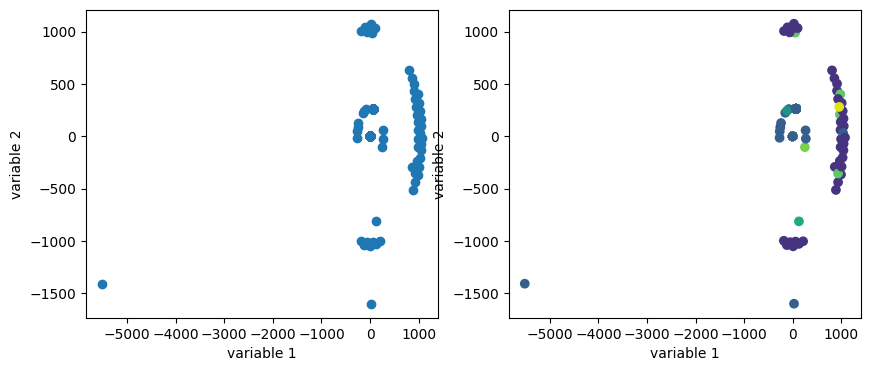

In [66]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df2['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [71]:
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [72]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: -0.00025852784246296775
Calinski Harabasz Score: 1095.68550674227
Davies Bouldin Score: 2.2292469141206253
Adjusted Rand Index: 2.730699322060483e-05
